# EE4375-2022: Extension of Fifth Lab Session: Assembly Using Map: Sequential and Distributed Version 

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method is employed. This lab session complements the lectures with slides available at [shared drive](https://mega.nz/fm/CcsEnLxL). 

## Import Packages

In [1]:
using LinearAlgebra
using Plots
using LaTeXStrings
using SparseArrays
using BenchmarkTools 

## Section 1/: 1D Galerkin FEM Code Using for-loop over Elements
The code in this section is the classical approach of performing a for-loop over the elements. A dense (instead of sparse) matrix is allocated. This code is documented elsewhere in the course. 

To do: 
- convert from script to function;
- check type-stability and runtime of the function; 

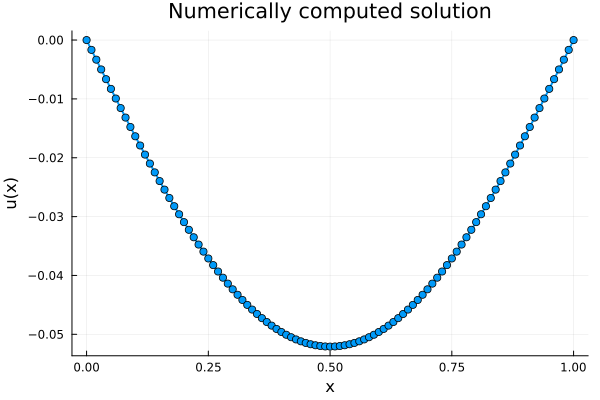

In [2]:
#..construct the mesh: generated uniform mesh with N elements   
N = 100; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [ [x[i], x[i+1]] for i in 1:N]
edges =  [ [i, i+1] for i in 1:N]; 

#..Set the source function 
fsource(x) = x*(x-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(N+1, N+1); 
f = zeros(N+1); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:N  

  xl, xr = points[i]
  floc = (xr-xl) * [fsource(xl) ; fsource(xr)];
  Aloc = (1/(xr-xl))*[1 -1; -1 1]; 

  f[edges[i]] += floc;
  A[edges[i], edges[i]] += Aloc;

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0; 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

In [3]:
xl, xr = points[2]

2-element Vector{Float64}:
 0.01
 0.02

## Section 2:/ Using map and map-do over the List of Elements 
In this section we illustrate the concept of map over a list.

To do:
- replace map() by lazy_map() 

### Section 1.2:/ Use of map of a function over list of values
Here we illustrate the concept of map over a list for a function with a single output (or return value).  

In [4]:
function times_two(x)
    return 2*x
end 

input = [1., 2., 3.]

output = map(times_two,input);

@show output

output = [2.0, 4.0, 6.0]


3-element Vector{Float64}:
 2.0
 4.0
 6.0

In [5]:
map(input) do i 
  times_two(i)
end

3-element Vector{Float64}:
 2.0
 4.0
 6.0

### Section 2.2:/ Use of map of a function with multiple outputs over a list of values
Here we illustrate the concept of splatting (denoted by ...) to treat functions with multiple outputs. 

In [6]:
function times_two_times_three(x)
    return 2*x, 3*x
end 

input = [1., 2., 3.]

output = map(times_two_times_three,input)

@show output

doubles, triplets = vcat.(output...)

@show doubles
@show triplets

output = [(2.0, 3.0), (4.0, 6.0), (6.0, 9.0)]
doubles = [2.0, 4.0, 6.0]
triplets = [3.0, 6.0, 9.0]


3-element Vector{Float64}:
 3.0
 6.0
 9.0

In [7]:
output = map(input) do i 
  times_two_times_three(i)
end

@show output

doubles, triplets = vcat.(output...)

@show doubles
@show triplets

output = [(2.0, 3.0), (4.0, 6.0), (6.0, 9.0)]
doubles = [2.0, 4.0, 6.0]
triplets = [3.0, 6.0, 9.0]


3-element Vector{Float64}:
 3.0
 6.0
 9.0

### Section 2.3:/ Use of map of a function typical for FEM assembly 
Here we illustrate the use of map for a function similar to FEM assembly.   

In [8]:
ff(x) = [1;1]
gg(x) = x*[1;1]
hh(x) = [1;1], x*[1;1]
fff = mapreduce(ff,vcat, [1 2 3])
ggg = mapreduce(gg,vcat, [1 2 3])
ggg1 = map(gg,[1 2 3])
hhh = map(hh, [1 2 3])
@show fff 
@show ggg
@show ggg1
@show hhh 

fff = [1, 1, 1, 1, 1, 1]
ggg = [1, 1, 2, 2, 3, 3]
ggg1 = [[1, 1] [2, 2] [3, 3]]
hhh = [([1, 1], [1, 1]) ([1, 1], [2, 2]) ([1, 1], [3, 3])]


1×3 Matrix{Tuple{Vector{Int64}, Vector{Int64}}}:
 ([1, 1], [1, 1])  ([1, 1], [2, 2])  ([1, 1], [3, 3])

## Section 3:/ FEM Assembly using map over elements 
In this section we use map to perform FEM assembly. 

To do: 
- replace map() by lazy_map()

### Section 1.3:/ Compute Area of Elements 
Here we use map and map-do to compute the area of the elements to illustrate the loop over elements using map. 

In [9]:
#..construct the mesh: see before 
N = 5; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..function to compute local matrix contributions.. 
function compute_elem_area(elem_id, p, e)
  xl, xr = points[elem_id] 
  area = xr - xl 
  return area
end

#..map over all elements to compute area of elements  
output = map(elem_id -> compute_elem_area(elem_id,points,edges), Vector(1:N));
@show output 

#..map-do over all elements to compute area of elements  
output2 = map(Vector(1:N)) do elem_id 
  compute_elem_area(elem_id,points,edges);
end 
@show output2  

output = [0.2, 0.2, 0.19999999999999996, 0.20000000000000007, 0.19999999999999996]
output2 = [0.2, 0.2, 0.19999999999999996, 0.20000000000000007, 0.19999999999999996]


5-element Vector{Float64}:
 0.2
 0.2
 0.19999999999999996
 0.20000000000000007
 0.19999999999999996

### Section 2.3:/ Intermediate Version of Assembly Using a Dense Matrix 
This version adds to global vector and matrix at each iteration of map. A dense matrix A is employed. This version is used as intermediate towards the next version. 

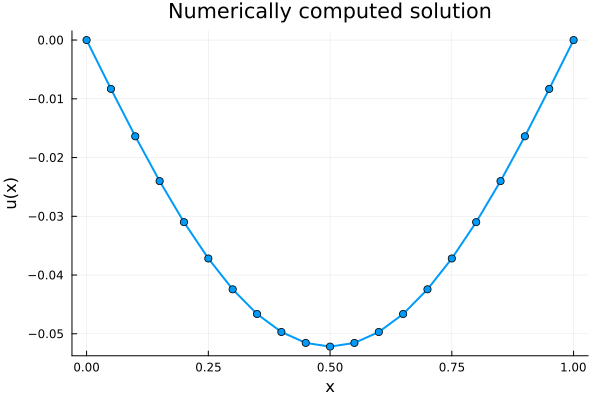

In [10]:
#..construct the mesh: see before 
N = 20; h = 1/N; Np1 = N+1; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..Set the source function 
fsource(x) = x*(x-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(Np1,Np1); 
f = zeros(Np1); 

#..compute on one element and add to vector and matrix 
function compute_elem_mat_and_vec!(A, f, elem_id)
  xl, xr = points[elem_id]
  floc = (xr-xl) * [fsource(xl) ; fsource(xr)]
  Aloc = (1/(xr-xl))*[1 -1; -1 1]

  f[edges[elem_id]] += floc
  A[edges[elem_id], edges[elem_id]] += Aloc
end 

#..map over all elements to assemble A and f 
map(elem_id -> compute_elem_mat_and_vec!(A, f, elem_id), Vector(1:length(edges)))

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;     A[1,2] = 0;        f[1]   = 0; 
A[end,end-1]=0; A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
p1=plot(x,u,shape=:circle,lw=2,legend=false)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")

### Section 3.3:/ Using Sparse Matrix  
Here a list of contributions per element is assembled. 

In [11]:
#..Intermediate solution.. 
#..construct the mesh
N = 4; h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..Set the source function 
fsource(x) = sin(pi*x*(x-1)); 

#..function to compute local matrix and vector contributions.. 
function compute_elem_vec_and_mat(elem_id, p, e)
  xl, xr = points[elem_id] 
  area   = xr - xl 
  elemI1 = [e[elem_id][1] e[elem_id][2]] 
  elemf  = area* [fsource(xl) fsource(xr)]  
  elemI2 = [ e[elem_id][1] e[elem_id][1] e[elem_id][2] e[elem_id][2] ] 
  elemJ2 = [ e[elem_id][1] e[elem_id][2] e[elem_id][1] e[elem_id][2] ]
  elemA  = (1/area)*[1 -1 -1 1]
  return elemI1, elemf, elemI2, elemJ2, elemA 
end

#..assemble list of elementary matrix contributions 
output = map(Vector(1:N)) do elem_id 
  compute_elem_vec_and_mat(elem_id, points, edges)
end

#..seperate arguments in the list using splatting 
I1, fvals, I2, J2, Avals = vcat.(output...)

#..assembly vector  
f = sparsevec(I1[:],fvals[:])
f = Vector(f)

#..assembly sparse matrix 
A = sparse(I2[:],J2[:],Avals[:])

#..need to take care of so-called splashing 
A[1,1] = 1;      A[1,2] = 0;        f[1]     = 0; 
A[end,end-1]=0;  A[end,end] = 1;    f[end] = 0;

#..solve the linear system
u = A \ f; 

#..plot the solution  
plot(x,u)

@show I2 
@show J2
@show Avals

I2 = [1 1 2 2; 2 2 3 3; 3 3 4 4; 4 4 5 5]
J2 = [1 2 1 2; 2 3 2 3; 3 4 3 4; 4 5 4 5]
Avals = [4.0 -4.0 -4.0 4.0; 4.0 -4.0 -4.0 4.0; 4.0 -4.0 -4.0 4.0; 4.0 -4.0 -4.0 4.0]


4×4 Matrix{Float64}:
 4.0  -4.0  -4.0  4.0
 4.0  -4.0  -4.0  4.0
 4.0  -4.0  -4.0  4.0
 4.0  -4.0  -4.0  4.0

## Section 4:/ Distributed Memory Distribution  
How to extract or deduce a partioning of the row indices from the partitioning of the element indices. 

In [21]:
using PartitionedArrays

In [25]:
#..generate partition of the list of elements 
np = 2 # number of partitions 
N = 4 # number of elements in the mesh 
ranks = LinearIndices((np,))
elem_partition = uniform_partition(ranks,N);
row_partition = uniform_partition(ranks,N+1);
@show ranks 
@show elem_partition
@show row_partition

ranks = [1, 2]
elem_partition = PartitionedArrays.LocalIndicesWithConstantBlockSize{1}[[1, 2], [3, 4]]
row_partition = PartitionedArrays.LocalIndicesWithConstantBlockSize{1}[[1, 2], [3, 4, 5]]


2-element Vector{PartitionedArrays.LocalIndicesWithConstantBlockSize{1}}:
 [1, 2]
 [3, 4, 5]

In [26]:
h = 1/N; 
x = Vector(0:h:1); 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
#..use comprehension to build both lists
points = [[x[i], x[i+1]] for i in 1:N] 
edges =  [[i, i+1] for i in 1:N] 

#..function to compute local matrix contributions.. 
function compute_elem_mat(elem_id, p, e)
  xl, xr = points[elem_id] 
  area  = xr - xl 
  elemI = [ e[elem_id][1] e[elem_id][1] e[elem_id][2] e[elem_id][2] ] 
  elemJ = [ e[elem_id][1] e[elem_id][2] e[elem_id][1] e[elem_id][2] ]
  elemA = (1/area)*[1 -1 -1 1]
  return elemI, elemJ, elemA 
end

#..loop over element in the partition or every subdomain  
IJV = map(elem_partition) do elem_subdomain 
    #..initialize 
    I, J, V = Vector{Int64}[], Vector{Int64}[], Vector{Float64}[] 
    #..loop over element in the subdomain   
    tt_subdomain = map(elem_subdomain) do elem_id
        compute_elem_mat(elem_id, points, edges)
    end 
    #..seperate arguments in the list using splatting 
    I_subdomain, J_subdomain, V_subdomain = vcat.(tt_subdomain...)
    @show I_subdomain
    @show J_subdomain
    @show V_subdomain    
    #..add to global list     
    push!(I, I_subdomain[:]) 
    push!(J, J_subdomain[:]) 
    push!(V, V_subdomain[:]) 
    I,J,V 
end

#@show IJV 

I,J,V = vcat.(IJV...)
@show I 
@show typeof(I)
@show J 
@show typeof(J)
@show V 
@show typeof(V)
@show elem_partition
@show typeof(elem_partition)

col_partition = row_partition
# A = sparse(I,J,V)
# A2 = psparse(I,J,V)
A2 = psparse!(I,J,V,row_partition,col_partition) |> fetch

I_subdomain = [1 1 2 2; 2 2 3 3]
J_subdomain = [1 2 1 2; 2 3 2 3]
V_subdomain = [4.0 -4.0 -4.0 4.0; 4.0 -4.0 -4.0 4.0]
I_subdomain = [3 3 4 4; 4 4 5 5]
J_subdomain = [3 4 3 4; 4 5 4 5]
V_subdomain = [4.0 -4.0 -4.0 4.0; 4.0 -4.0 -4.0 4.0]
I = [[1, 2, 1, 2, 2, 3, 2, 3], [3, 4, 3, 4, 4, 5, 4, 5]]
typeof(I) = Vector{Vector{Int64}}
J = [[1, 2, 2, 3, 1, 2, 2, 3], [3, 4, 4, 5, 3, 4, 4, 5]]
typeof(J) = Vector{Vector{Int64}}
V = [[4.0, 4.0, -4.0, -4.0, -4.0, -4.0, 4.0, 4.0], [4.0, 4.0, -4.0, -4.0, -4.0, -4.0, 4.0, 4.0]]
typeof(V) = Vector{Vector{Float64}}
elem_partition = PartitionedArrays.LocalIndicesWithConstantBlockSize{1}[[1, 2], [3, 4]]
typeof(elem_partition) = Vector{PartitionedArrays.LocalIndicesWithConstantBlockSize{1}}


5×5 PSparseMatrix{SparseMatrixCSC{Float64, Int64}} partitioned into 2 parts


In [88]:
a = Vector([1,2])
b = Vector([3,4])
I = Vector([])
@show a
@show b
@show I 
push!(I,a)
push!(I,b)
@show I 

a = [1, 2]
b = [3, 4]
I = Any[]
I = Any[[1, 2], [3, 4]]


2-element Vector{Any}:
 [1, 2]
 [3, 4]

In [42]:
?fetch

search: fetch unsafe_trunc RankDeficientException



```
fetch(c::Channel)
```

Wait for and get the first available item from the channel. Does not remove the item. `fetch` is unsupported on an unbuffered (0-size) channel.

---

```
fetch(t::Task)
```

Wait for a Task to finish, then return its result value. If the task fails with an exception, a `TaskFailedException` (which wraps the failed task) is thrown.

---

```
fetch(x::Future)
```

Wait for and get the value of a [`Future`](@ref). The fetched value is cached locally. Further calls to `fetch` on the same reference return the cached value. If the remote value is an exception, throws a [`RemoteException`](@ref) which captures the remote exception and backtrace.

---

```
fetch(c::RemoteChannel)
```

Wait for and get a value from a [`RemoteChannel`](@ref). Exceptions raised are the same as for a [`Future`](@ref). Does not remove the item fetched.
